# Internet Ads - Hedgeable Data Science Challenge
by Christopher Lettieri  

### Understanding the Question

Given a dataset encoding 1,558 features determine whether an image is an ad or a non ad image.  This is a supervised classification problem.

### Load & Inspect Data

Using some custom functions I wrote in 'data_functions.py' I will load the dataset and begin to explore.

In [1]:
import pandas as pd
import numpy as np
from data_functions import load_data_with_col_names

df = load_data_with_col_names('data.csv', 'column.names.txt')
df.head()

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,is_ad
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [2]:
#Check for missing values
df.isnull().sum()

height                       903
width                        901
aratio                       910
local                         15
url*images+buttons             0
url*likesbooks.com             0
url*www.slake.com              0
url*hydrogeologist             0
url*oso                        0
url*media                      0
url*peace+images               0
url*blipverts                  0
url*tkaine+kats                0
url*labyrinth                  0
url*advertising+blipverts      0
url*images+oso                 0
url*area51+corridor            0
url*ran+gifs                   0
url*express-scripts.com        0
url*off                        0
url*cnet                       0
url*time+1998                  0
url*josefina3                  0
url*truluck.com                0
url*clawnext+gif               0
url*autopen.com                0
url*tvgen.com                  0
url*pixs                       0
url*heartland+5309             0
url*meadows+9196               0
          

In [3]:
#Check if any non-numeric columns
df.select_dtypes(exclude=[np.number]).shape[1]

0

### Data Exploration

The project description says that we have 1,558 features.  Only 3 features are continuous, the rest are binary.  Let's explore some of these continuous features to get a feel for the data.

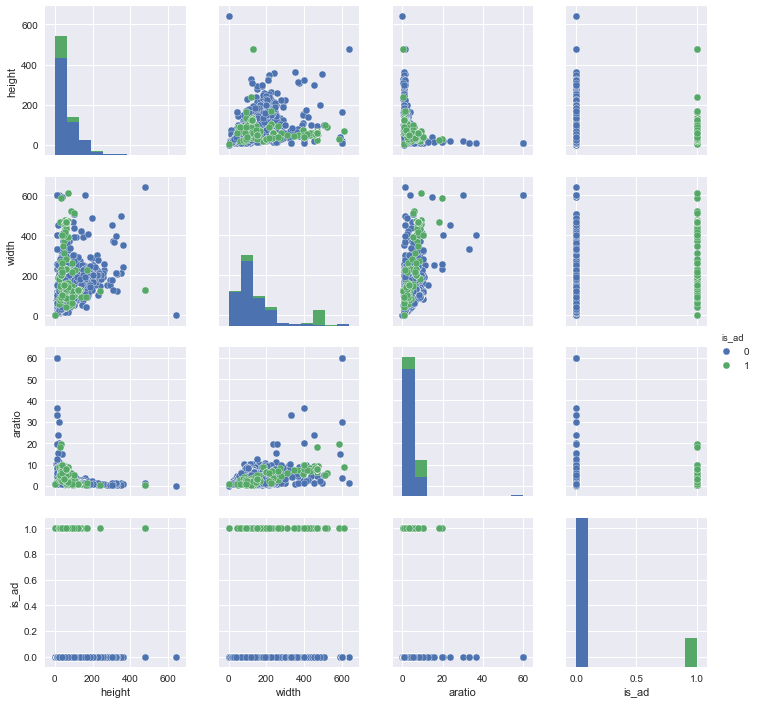

In [4]:
%matplotlib inline 
import seaborn as sns

continous_cols = ['height', 'width', 'aratio']
#Temporarily drop NaN to create the plot
sns.pairplot(df[continous_cols+['is_ad']].dropna(), hue="is_ad")

The pairplot above is showing that there is a tendency for ads to have a larger height and smaller aspect ratio than non ads.  This visualziation is leading me to belive that width and especially height and aspect ratio will have predictive power in my final model.

### Exploring non-continous features

Since we have 1,555 binary variables I will attempt to explore only the most significant features.  I will determine significance for a feature by seeing what % that feature tests positive for either class.  My thinking here is a lot of features have very few samples that test positive in either case, relative to the total training set.  To reduce the noise in this dataset I want to select only the features that have a decent sample size for either the ad class or non ad class.

There are 3,279 instances (2820 are non ads, and 459 are ads) -Note-the instructions say 2821 and 458, but my findings differ here by 1.  I will group the data by whether an ad or non ad, then sum the positive instances for each feature.  From there I will determine the % of positive samples given the total size of each class, and then select only those columns that have a significant number of samples and relatively big difference between the two classes.

In [11]:
#Group non-continous columns by label
grouped_df = df.drop(continous_cols, axis=1).groupby('is_ad').sum()

#Append new rows to calculate % of each class this feature tests positive for
grouped_df = grouped_df.append(grouped_df.iloc[0]/2820) #percentage of non ad
grouped_df = grouped_df.append(grouped_df.iloc[1]/459) #percentage of ad
#Append row that is max % of either class for that feature (used to filter)
grouped_df = grouped_df.append(grouped_df.iloc[2:].max(), ignore_index=True) 

grouped_df.head()

,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,url*peace+images,url*blipverts,url*tkaine+kats,...,caption*of,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you
0,2152.000000,14.000000,38.000000,15.000000,11.000000,13.00000,8.000000,11.000000,0.000000,30.000000,...,20.000000,15.000000,12.000000,4.000000,6.000000,21.000000,7.000000,7.000000,14.000000,3.000000
1,352.000000,0.000000,0.000000,0.000000,0.000000,0.00000,30.000000,0.000000,16.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,35.000000,37.000000,18.000000,2.000000
2,0.763121,0.004965,0.013475,0.005319,0.003901,0.00461,0.002837,0.003901,0.000000,0.010638,...,0.007092,0.005319,0.004255,0.001418,0.002128,0.007447,0.002482,0.002482,0.004965,0.001064
3,0.766885,0.000000,0.000000,0.000000,0.000000,0.00000,0.065359,0.000000,0.034858,0.000000,...,0.000000,0.000000,0.000000,0.008715,0.008715,0.000000,0.076253,0.080610,0.039216,0.004357
4,0.766885,0.004965,0.013475,0.005319,0.003901,0.00461,0.065359,0.003901,0.034858,0.010638,...,0.007092,0.005319,0.004255,0.008715,0.008715,0.007447,0.076253,0.080610,0.039216,0.004357


In [12]:
#Explore the distribution of % belonging to a class for each feature
grouped_df.iloc[4].quantile([.1,.25,.5,.75,.9])

0.10    0.003546
0.25    0.004357
0.50    0.007092
0.75    0.021786
0.90    0.032680
Name: 4, dtype: float64

In [14]:
#Get list of columns of only significantly utilized features
def get_column_list_at_threshold(df, min_threshold):
    '''(DataFrame, float) -> list
    
    Given the grouped dataframe and a minimum threshold, get
    a list of column names that have >= the % of positive samples
    as the minimum threshold.
    '''
    cols = df.iloc[4] >= min_threshold
    col_list = cols[cols==True].index.tolist()
    return col_list

sig_cols_75 = get_column_list_at_threshold(grouped_df, 0.021786)
sig_cols_90 = get_column_list_at_threshold(grouped_df, 0.03268)
len(sig_cols_90)

150

So now I have 3 sets of features to test a model with.  The above was essentialy a manual way of doing some dimensionality reduction.  The assumption behind this is that fewer features may lead to a more robust model.

### Prepare Data for Modeling

First I will split the data into a training and testing set.  I use a stratified train/test split to ensure that the classes are evenly distributed between training and testing sets.

In [18]:
from sklearn.model_selection import train_test_split

#Get full features
X = df.drop('is_ad', axis=1).values
y = df['is_ad'].values
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, train_size=.8, 
                                                                        test_size=.2, stratify=y)

In [32]:
#Get top 25% of features
X = df[sig_cols_75].values
y = df['is_ad'].values
X_train_75, X_test_75, y_train_75, y_test_75 = train_test_split(X, y, train_size=.8, 
                                                                test_size=.2, stratify=y)

In [25]:
#Get top 10% of features
X = df[sig_cols_90].values
y = df['is_ad'].values
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X, y, train_size=.8, 
                                                                test_size=.2, stratify=y)

### Modeling

Here I will first cross-validate my training set with a few different approaches to this problem.  Then I will select one model and tune it.  Also I use SkLearn's Imputer class to impute the missing values of the continuous features.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

#Random Forest - ALL Features
#Initialize Model
clf = Pipeline([("imputer", Imputer(strategy="median", axis=0)),
                ("rf", RandomForestClassifier(random_state=5, n_estimators=100))])
#Create KFold
skf = StratifiedKFold(n_splits=5, random_state=5)
#Cross Val
cross_val_results = cross_val_score(clf, X_train_full, y_train_full, cv=skf, scoring='accuracy')
print cross_val_results.mean()

0.97330422812


In [33]:
#Random Forest - Top 25% Features
#Initialize Model
clf = Pipeline([("imputer", Imputer(strategy="median", axis=0)),
                ("rf", RandomForestClassifier(random_state=5, n_estimators=100))])
#Create KFold
skf = StratifiedKFold(n_splits=5, random_state=5)
#Cross Val
cross_val_results = cross_val_score(clf, X_train_75, y_train_75, cv=skf, scoring='accuracy')
print cross_val_results.mean()

0.963780385425


In [30]:
#Random Forest - Top 10% Features
#Initialize Model
clf = Pipeline([("imputer", Imputer(strategy="median", axis=0)),
                ("rf", RandomForestClassifier(random_state=5, n_estimators=100))])
#Create KFold
skf = StratifiedKFold(n_splits=5, random_state=5)
#Cross Val
cross_val_results = cross_val_score(clf, X_train_90, y_train_90, cv=skf, scoring='accuracy')
print cross_val_results.mean()

0.961483058356


### Tune Model

So it seems my idea of manually reducing features hasn't helped to improve the model.  Given the scope of time on this project I will just move forward with a basic decision tree on the full data set.  Now I will use GridSearch to tune the model before building a final model to test.

In [37]:
#First need Impute the missing values and fill them in so GridSearch will work
imp = Imputer(strategy="median", axis=0)
X_train_full_transformed = imp.fit_transform(X_train_full)

In [38]:
#Run GridSearchCV for optimal parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split' : [2, 4, 10, 20, 40],
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'log2', None]

}

#Initialize Model & Kfold
rf = RandomForestClassifier(random_state=5, n_estimators=50)
skf = StratifiedKFold(n_splits=3, random_state=5)
#Initalize & Fit GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train_full_transformed, y_train_full)

print "Best Score: %f" % grid_search.best_score_
print grid_search.best_params_

Best Score: 0.974457
{'max_features': 'auto', 'min_samples_split': 4, 'criterion': 'gini'}


### Test Final Model

Now we can train a final model using the optimal parameters.  I will also use a higher tree count since this model is only being trained once.  After fitting the model I will score it on the testing data.

In [40]:
#Build final model
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=4, criterion='gini', 
                            max_features='auto', n_jobs=-1)
rf.fit(X_train_full_transformed, y_train_full)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [43]:
from sklearn.metrics import accuracy_score

#First impute test set
X_test_full_transformed = imp.fit_transform(X_test_full)

#Make Predictions on test set
predictions = rf.predict(X_test_full_transformed)

score = accuracy_score(y_test_full, predictions)
print "Model Accuracy: " + str(score)

Model Accuracy: 0.980182926829


### Exporting the Model

Using joblib from sklearn I will export the model.  Joblib is similar to pickle but according to the sklearn documentation, it is more efficient for objects that carry large numpy arrays internally (ie. our model).

In [45]:
from sklearn.externals import joblib

#Save the current model
joblib.dump(rf, 'final_model.pkl') 

['final_model.pkl']

### Conclusion

This final model scored a little over 98% accuracy on predicting whether an image is an ad or non ad from our testing set.  This was done with the full feature set and a lightly tuned random forest.  

Given more time on this project some further steps I would explore are:  

**New Features**  
-Bool feature for containing NaN values or not  

**Handling Missing Values**  
-Impute using different metrics  
-Impute by label distribution, not total distribution

**Other ML Aproaches**  
-XGBoost  
-Ensembling several algorithms

### Running this Model again

I made a script called 'run_model.py' which by default will load a data file of the same structure and shape as the data set given, named 'data.csv', and will load the model from 'final_model.pkl'.  It will print out the accuracy score of this model on the new data set.  

This model was built using:  
Python 2.7.13  
Sklearn 0.18.1  
NumPy 1.11.3  
Pandas 0.19.2  

To simply re-use the model on your own, without my 'run_model.py' then use the following to load the model from the file I submitted:

In [ ]:
from sklearn.externals import joblib
clf = joblib.load(file_name) #replace filename with 'final_model.pkl'